# Import Libraries, Datasets & Declare Functions

In [1]:
# Import libraries | Standard
import pandas as pd
import numpy as np
import os
import datetime
import warnings
from time import time

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor

# Pretty display for notebooks
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)  

In [3]:
#pd.set_option('display.max_rows', None)

In [4]:
warnings.filterwarnings('ignore')

In [5]:
def distribution(data, features, transformed = False):
    """
    Visualization code for displaying distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(features):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Distributions of Continuous Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

In [6]:
def eval_train_predict(learner, sample_size, train_X, train_y, test_X, test_y): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set       
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
                   
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [7]:
def eval_visualize(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize = (18,8))

    # Constants
    bar_width = 0.1
    colors = ['#A00000','#00A0A0','#00A000','#E3DAC9','#555555', '#87CEEB']
    metrics = ['time_train', 'time_pred', 'WMAE']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(metrics):
            # Creative plot code
            ax[j%3].bar(0+k*bar_width, results[learner][0][metric], width = bar_width, color = colors[k])
            ax[j%3].set_xlabel("Models")
            ax[j%3].set_xticklabels([''])
                
    # Add unique y-labels
    ax[0].set_ylabel("Time (in seconds)")
    ax[1].set_ylabel("Time (in seconds)")
    ax[2].set_ylabel("WMAE")
    
    # Add titles
    ax[0].set_title("Model Training")
    ax[1].set_title("Model Predicting")
    ax[2].set_title("WMAE on Testing Set")
 
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.43), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [8]:
def train_predict(learner, train_X, train_y, test_X, test_y, verbose=0): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - train_X: features training set
       - train_y: sales training set
       - test_X: features testing set
       - test_y: sales testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X, train_y)
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Weighted Mean Absolute Error on Test Set
    results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))

    #Extract the feature importances
    importances = learner.feature_importances_

    # Success
    print("Learner Name :", learner.__class__.__name__)
    print("Training     :", round(results['time_train'],2), "secs /", len(train_y), "records")
    print("Predicting   :", round(results['time_pred'],2), "secs /", len(test_y), "records")
    print("Weighted MAE :", round(results['WMAE'],2))

    if verbose == 1:
        # Plot
        print("\n<Feature Importance>\n")
        feature_plot(importances, train_X, train_y, 10)

        print("\n<Feature Weightage>\n")
        topk = len(train_X.columns)
        indices = np.argsort(importances)[::-1]
        columns = train_X.columns.values[indices[:topk]]
        values = importances[indices][:topk]

        for i in range(topk):
            print('\t' + columns[i] + (' ' * (15 - len(columns[i])) + ': ' + str(values[i])))
            
        print("\n<Learner Params>\n", model.get_params())
    
    # Return the model & predictions
    return (learner, predictions)

In [9]:
def feature_plot(importances, train_X, train_y, topk=5):
    
    # Display the most important features
    indices = np.argsort(importances)[::-1]
    columns = train_X.columns.values[indices[:topk]]
    values = importances[indices][:topk]

    # Creat the plot
    fig = plt.figure(figsize = (18,5))
    plt.title("Normalized Weights for First " + str(topk) + " Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(topk), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(topk) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(topk), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

In [10]:
def reduce_mem_usage(df, verbose=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
def compute_weights(holidays):
    return holidays.apply(lambda x: 1 if x==0 else 5)

In [12]:
def weighted_mean_absolute_error(pred_y, test_y, weights):
    return 1/sum(weights) * sum(weights * abs(test_y - pred_y))

In [20]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

cnt = 0
env = 'Outside Kaggle'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cnt += 1
        print(os.path.join(dirname, filename))
        
if cnt > 0:
    env = 'Kaggle Kernel'

In [21]:
print('Environment:', env)

Environment: Outside Kaggle


In [22]:
# Read input files
if env == 'Kaggle Kernel':
    features = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv")
    stores = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
    train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv")
    test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv")
else:    
    features = pd.read_csv("data/features.csv")
    stores = pd.read_csv("data/stores.csv")
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")

In [14]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Memory usage of dataframe is 13.27 MB
Memory usage after optimization is: 6.03 MB
Decreased by 54.5%
Memory usage of dataframe is 2.74 MB
Memory usage after optimization is: 1.21 MB
Decreased by 56.0%


# Data Exploration

## 1. Stores Data

In [15]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [16]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [17]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [18]:
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


In [19]:
stores['Size'].groupby(stores['Type']).mean()

Type
A    177247.727273
B    101190.705882
C     40541.666667
Name: Size, dtype: float64

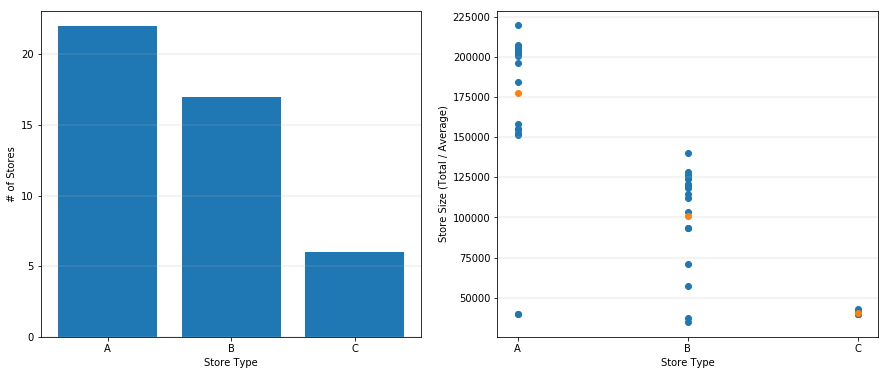

In [20]:
# Create figure
#plt.figure()
#plt.scatter(stores['Type'], stores['Store'])
#plt.ylabel('Store ID')
#plt.xlabel('Store Type')

fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).count())
ax[0].set_ylabel('# of Stores')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].scatter(stores['Type'], stores['Size'])
ax[1].scatter(stores['Type'].unique(), stores['Size'].groupby(stores['Type']).mean()) #Store Type Average Store Size Vs 
ax[1].set_ylabel('Store Size (Total / Average)')
ax[1].set_xlabel('Store Type')
ax[1].yaxis.grid(True, linewidth=0.3)

#plt.figure(figsize=(6,6))
#plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
#plt.xlabel('fraction of rows with missing data')
#plt.barh(np.arange(len(features_missing)), features_missing)

In [21]:
stores[(stores['Size'] < 40000) & (~stores['Type'].isin(['C']))]

,Store,Type,Size
2,3,B,37392
4,5,B,34875
32,33,A,39690
35,36,A,39910


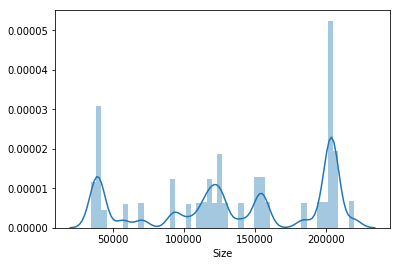

In [41]:
#Explore Weekly Sales - histogram
sns.distplot(train['Size'])

###### Takeaways: 
1. Column TYPE is a candidate for one-hot encoding. 
2. Most stores are of TYPE='A'. Only a few stores are of TYPE='C'.
3. TYPE columns seem to be linked to Store Size. Average store size of TYPE 'A' is ~ 175k, TYPE 'B' is ~ 100k and TYPE 'C' is ~40k
4. Four stores [3, 5, 33 & 36] whose size is < 40k, seem to have been incorrectly tagged as Types A & B

## 2. Features Data

In [22]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [23]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


In [24]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [25]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [26]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

<BarContainer object of 12 artists>

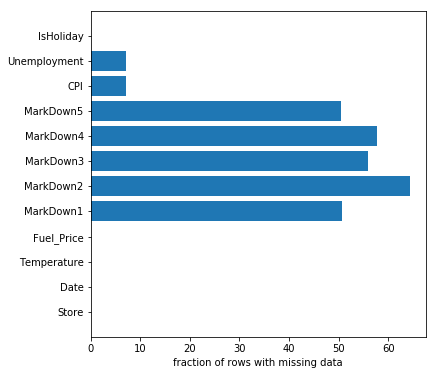

In [27]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

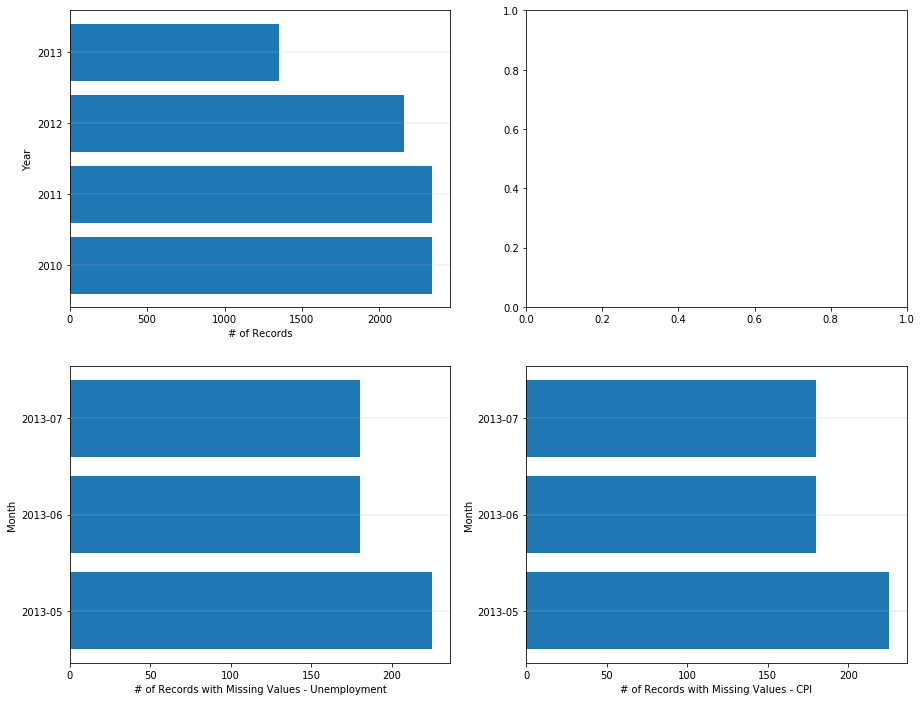

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (15,12))

# Plot 1: Year Vs # of Records
ax[0,0].barh(features['Date'].str.slice(start=0, stop=4).unique(), 
          features['Date'].str.slice(start=0, stop=4).value_counts())
ax[0,0].set_xlabel('# of Records')
ax[0,0].set_ylabel('Year')
ax[0,0].yaxis.grid(True, linewidth=0.3)

# Plot 2: Month Vs # of Records with Missing Values - Unemployment
ax[1,0].barh(features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts())
ax[1,0].set_xlabel('# of Records with Missing Values - Unemployment')
ax[1,0].set_ylabel('Month')
ax[1,0].yaxis.grid(True, linewidth=0.3)

# Plot 3: Month Vs # of Records with Missing Values - CPI
ax[1,1].barh(features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].unique(), 
          features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts())
ax[1,1].set_xlabel('# of Records with Missing Values - CPI')
ax[1,1].set_ylabel('Month')
ax[1,1].yaxis.grid(True, linewidth=0.3)

#plt.figure(figsize=(6,6))
#plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
#plt.xlabel('fraction of rows with missing data')
#plt.barh(np.arange(len(features_missing)), features_missing)

In [29]:
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

In [30]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [31]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

In [32]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
...                   ...           ...
2     2011-02  212.727665         8.028
      2011-03  213.877488         8.028
      2011-04  214.908582         7.931
      2011-05  215.398826         7.931
      2011-06  214.754360         7.931
      2011-07  214.998246         7.852
      2011-08  215.291750         7.852
      2011-09  215.810080         7.852
      2011-10  217.047711         7.441
      2011-11  217.777737         7.441
      2011-12  218.792544         7.441
      2012-01  219.558147         7.057
      2012-02  220.014484         7.057
      2012-03  220.791516         7.057
      2012-04  221.170021         6.891
      2012-05  221.358968         6.891
      2012-06  221.419302         6.891
      2012-07  221.557961         6.565
      2012-08  221.721490         6.565
      2012-09  222.331393         6.565
      2012-10  222.992375         6.170
      2012-11  223.159882         6.170
      2012-12  223.427985         6.170
      2013-01  223.821473         6.237
      2013-02  223.925989         6.237
      2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [33]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


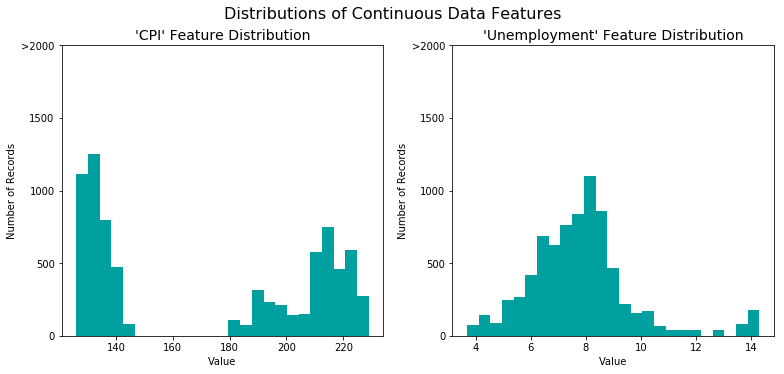

In [55]:
#Explore Distribution
distribution(features, ['CPI','Unemployment'])

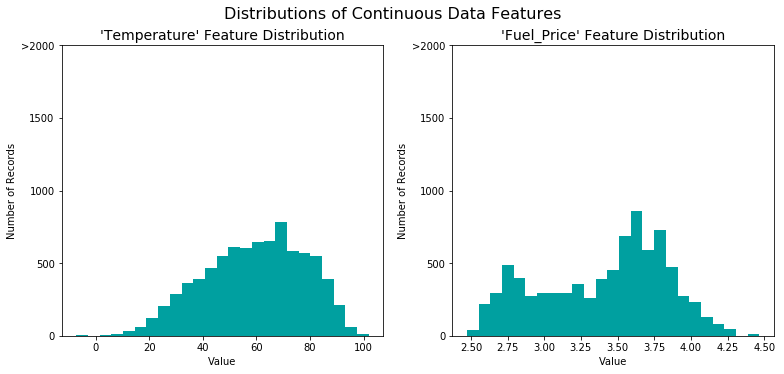

In [56]:
#Explore Distribution
distribution(features, ['Temperature','Fuel_Price'])

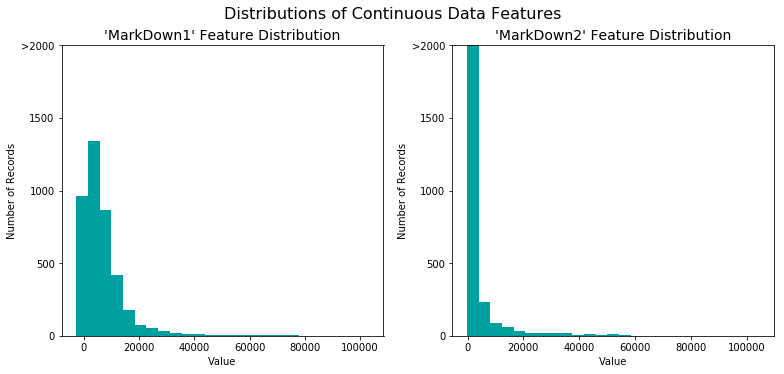

In [57]:
#Explore Distribution
distribution(features, ['MarkDown1','MarkDown2'])

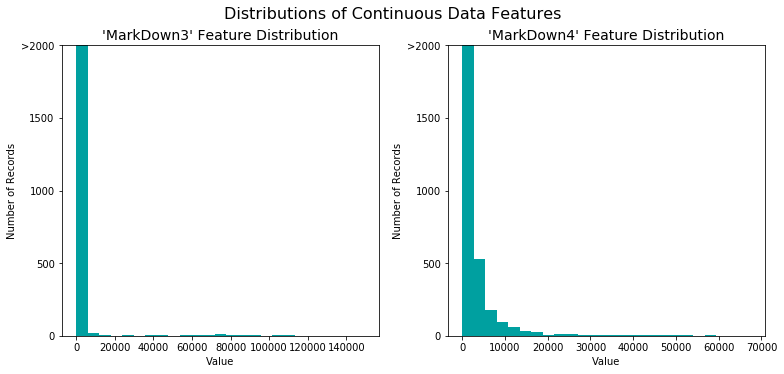

In [58]:
#Explore Distribution
distribution(features, ['MarkDown3','MarkDown4'])

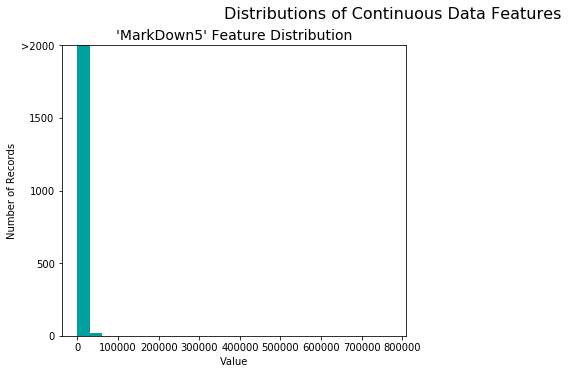

In [59]:
#Explore Distribution
distribution(features, ['MarkDown5'])

###### Takeaways: 
1. Data requires pre-processing
2. Column(s) ISHOLIDAY has been validated
3. Column(s) UNEMPLOYMENT & CPI have missing values for May, Jun & Jul 2013. For these columns as the values dont change significantly month on month, value from Apr 2013 would be propogated over for each store. 
4. Column(s) MARKDOWN* have missing values for 2010 (entire year) and 2011 (until Nov). Additionally, there are missing values for other other dates as well. 
5. CPI and UNEMPLOYMENT value are a bit skewed. MARKDOWN* columns are skewed. 

## 3. Train Data

In [34]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.500000,False
1,1,1,2010-02-12,46039.488281,True
2,1,1,2010-02-19,41595.550781,False
3,1,1,2010-02-26,19403.539062,False
4,1,1,2010-03-05,21827.900391,False


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int8
Dept            421570 non-null int8
Date            421570 non-null object
Weekly_Sales    421570 non-null float32
IsHoliday       421570 non-null bool
dtypes: bool(1), float32(1), int8(2), object(1)
memory usage: 6.0+ MB


In [36]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15978.299805
std,12.785297,30.492054,22707.693359
min,1.000000,1.000000,-4988.939941
25%,11.000000,18.000000,2079.649902
50%,22.000000,37.000000,7612.029785
75%,33.000000,74.000000,20205.852051
max,45.000000,99.000000,693099.375000


In [37]:
# Explore Date Range
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

In [38]:
# Validate Holidays
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [39]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

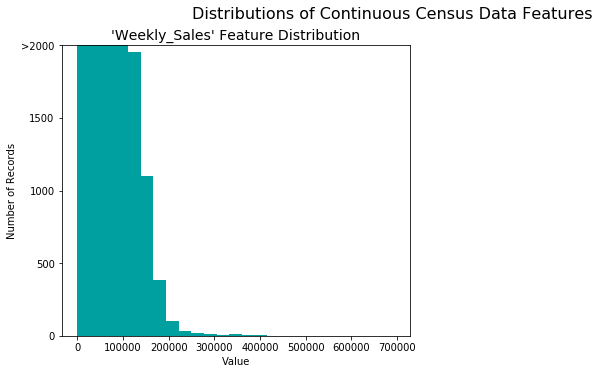

In [53]:
#Explore Distribution
distribution(train, ['Weekly_Sales'])

In [41]:
train['Store'][train['Weekly_Sales'] < 0].count()

1285

In [42]:
train_outliers = pd.merge(train, stores, how='left', on=['Store'])

In [43]:
# Average Weekly Sales by Store Type
train_outliers.groupby(['Type'])['Weekly_Sales'].mean()

Type
A    20099.568359
B    12237.076172
C     9519.532227
Name: Weekly_Sales, dtype: float32

In [44]:
# Average Weekly Sales for possibly misclassified Stores
train_outliers = train_outliers[train_outliers['Store'].isin([3,5,33,36])]
train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean()

Store  Type
3      B       6373.034180
5      B       5053.416016
33     A       5728.414062
36     A       8584.412109
Name: Weekly_Sales, dtype: float32

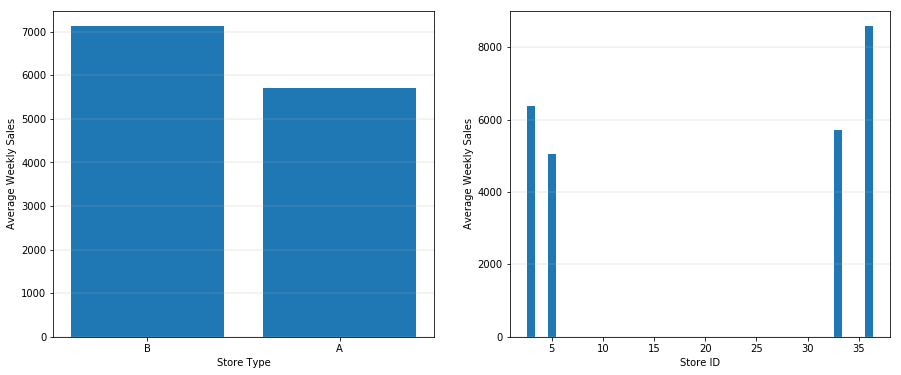

In [45]:
# Average Weekly Sales by Store Type
fig, ax = plt.subplots(1, 2, figsize = (15,6))
ax[0].bar(train_outliers['Type'].unique(), train_outliers.groupby(['Type'])['Weekly_Sales'].mean())
ax[0].set_ylabel('Average Weekly Sales')
ax[0].set_xlabel('Store Type')
ax[0].yaxis.grid(True, linewidth=0.3)

ax[1].bar([3,5,33,36], train_outliers.groupby(['Store','Type'])['Weekly_Sales'].mean())
ax[1].set_ylabel('Average Weekly Sales')
ax[1].set_xlabel('Store ID')
ax[1].yaxis.grid(True, linewidth=0.3)

In [46]:
train_outliers = None

###### Takeaways: 
1. Column DATE is non-numeric and is a candidate for pre-processing.
2. 1285 records with Weekly Sales < 0
3. Data spans years 2010, 2011 and 2012
4. As suspected above, four stores [3, 5, 33 & 36] seem to have incorrectly classified as Type A & B. Average Weekly Sales for these stores is in line with the average for Type C. Hence, these would need to be reclassified as Type C.

## 4. Test Data

In [47]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int8
Dept         115064 non-null int8
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int8(2), object(1)
memory usage: 1.2+ MB


In [49]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [50]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [51]:
# Validate Holidays
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [52]:
test['Date'][test['IsHoliday'].isin([1])][~test['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

###### Takeaways: 
1. Column DATE is non-numeric and is a candidate for pre-processing.
2. Data spans years 2012 and 2013

# Data Pre-Processing

## 1. Missing/Incorrect Values

### Stores Data | Correct Type for 4 stores

In [53]:
stores[stores['Store'].isin([3,5,33,36])].index

Int64Index([2, 4, 32, 35], dtype='int64')

In [54]:
stores.iat[2, 1] = stores.iat[4, 1] = stores.iat[32, 1] = stores.iat[35, 1] = 'C'

### Features Data | Negative values for MarkDowns:

In [55]:
features['MarkDown1'] = features['MarkDown1'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown2'] = features['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown3'] = features['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown4'] = features['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
features['MarkDown5'] = features['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

### Features Data | NaN values for multiple columns:

#### Columns: CPI and Unemployment
As noted above, columns are missing values for 3 months May, Jun & Jul 2013. Values from Apr 2019 would be propogated to records with missing values. 

In [56]:
%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 2.43 s, sys: 1.51 ms, total: 2.43 s
Wall time: 2.43 s


#### Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5
As noted above, columns MARKDOWN* are missing values for the whole of 2010 and 2011 (upto Nov). For each store, 2012 values would be copied over to records with missing values. Also, to facilitate the copy, new columns WEEK and YEAR would be derived from DATE.

In [57]:
%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3.76 s, sys: 1.21 ms, total: 3.76 s
Wall time: 3.77 s


In [58]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [59]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [60]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]        

CPU times: user 1min 3s, sys: 174 ms, total: 1min 3s
Wall time: 1min 3s


In [61]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [62]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

### Train Data | Negative Values for Weekly Sales

In [63]:
train['Weekly_Sales'] = train['Weekly_Sales'].apply(lambda x: 0 if x < 0 else x)

## 2. Merge Datasets

### Merge the following datasets:
1. Stores + Features + Train
2. Stores + Features + Test
3. Remove duplicate columns from each dataset

In [64]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [66]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [67]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [68]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [69]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

## 3. Feature Engineering

### Column #1: IsHoliday
Column has boolean values and would ned converted to numeric. 

In [70]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

### Column #2: Type
Column is categorical and would be converted to numeric via one-hot encoding. 

In [71]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

### Column #3: Week
New numeric column being created to replace YEAR. 

In [72]:
train['Week'] = test['Week'] = 0

In [73]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3min 42s, sys: 16.1 ms, total: 3min 42s
Wall time: 3min 42s


In [74]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 58.2 s, sys: 4.02 ms, total: 58.2 s
Wall time: 58.2 s


In [75]:
# Create checkpoint
train.to_csv('train_prescaled.csv', index=False)
test.to_csv('test_prescaled.csv', index=False)

In [20]:
# Restore checkpoint
train = pd.read_csv("train_prescaled.csv")
test = pd.read_csv("test_prescaled.csv")

In [21]:
# Create Submission dataframe
submission = test[['Store', 'Dept', 'Date']].copy()
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

### Log Transform Skewed Features

In [22]:
skewed = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
train[skewed] = train[skewed].apply(lambda x: np.log(x + 1))
test[skewed] = test[skewed].apply(lambda x: np.log(x + 1))

### Scale Datasets

In [23]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = ['Store', 'Dept', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 
             'CPI', 'Unemployment', 'Week', 'Type_A', 'Type_B', 'Type_C',
             'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train_scaled = pd.DataFrame(data = train)
train_scaled[numerical] = scaler.fit_transform(train[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,0.0,0.0,2010-02-05,24924.500000,0.0,0.630267,0.434149,0.050100,0.917362,0.708063,0.426749,0.934038,0.637068,0.840500,0.405118,0.078431,1.0,0.0,0.0
1,0.0,0.0,2010-02-12,46039.488281,1.0,0.630267,0.396967,0.038076,0.837532,0.765186,0.388691,0.813400,0.651916,0.841941,0.405118,0.098039,1.0,0.0,0.0
2,0.0,0.0,2010-02-19,41595.550781,0.0,0.630267,0.410861,0.021042,0.807352,0.805683,0.199711,0.812734,0.599926,0.842405,0.405118,0.117647,1.0,0.0,0.0
3,0.0,0.0,2010-02-26,19403.539062,0.0,0.630267,0.476419,0.044589,0.802568,0.772703,0.120444,0.639178,0.664288,0.842707,0.405118,0.137255,1.0,0.0,0.0
4,0.0,0.0,2010-03-05,21827.900391,0.0,0.630267,0.475147,0.076653,0.846604,0.636735,0.207143,0.912106,0.663597,0.843008,0.405118,0.156863,1.0,0.0,0.0


In [24]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.fit_transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

,Store,Dept,Date,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,0.0,0.0,2012-11-02,0.0,0.630267,0.573142,0.410215,0.764004,0.765027,0.331330,0.739574,0.583883,0.943588,0.443438,0.843137,1.0,0.0,0.0
1,0.0,0.0,2012-11-09,0.0,0.630267,0.627334,0.352753,0.809346,0.727139,0.312245,0.761595,0.643629,0.943778,0.443438,0.862745,1.0,0.0,0.0
2,0.0,0.0,2012-11-16,0.0,0.630267,0.551172,0.303272,0.795164,0.508483,0.390422,0.634379,0.648929,0.944101,0.443438,0.882353,1.0,0.0,0.0
3,0.0,0.0,2012-11-23,1.0,0.630267,0.581472,0.270551,0.587747,0.147059,0.942015,0.482657,0.421811,0.944603,0.443438,0.901961,1.0,0.0,0.0
4,0.0,0.0,2012-11-30,0.0,0.630267,0.545862,0.267358,0.676381,0.000000,0.692664,0.452859,0.652772,0.945105,0.443438,0.921569,1.0,0.0,0.0


In [25]:
# Free up memory
train = test = features = stores = None

In [26]:
# Create checkpoint
train_scaled.to_csv('train_scaled.csv', index=False)
test_scaled.to_csv('test_scaled.csv', index=False)

In [27]:
# Restore checkpoint
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

In [14]:
# Reduce memory usage
train_scaled=reduce_mem_usage(train_scaled)
test_scaled=reduce_mem_usage(test_scaled)

Memory usage of dataframe is 61.11 MB
Memory usage after optimization is: 18.49 MB
Decreased by 69.7%
Memory usage of dataframe is 15.80 MB
Memory usage after optimization is: 4.61 MB
Decreased by 70.8%


In [28]:
# Drop non-numeric columns
train_scaled.drop(columns=['Date'], axis=1, inplace=True)
test_scaled.drop(columns=['Date'], axis=1, inplace=True)

### Analyze Feature Correlation

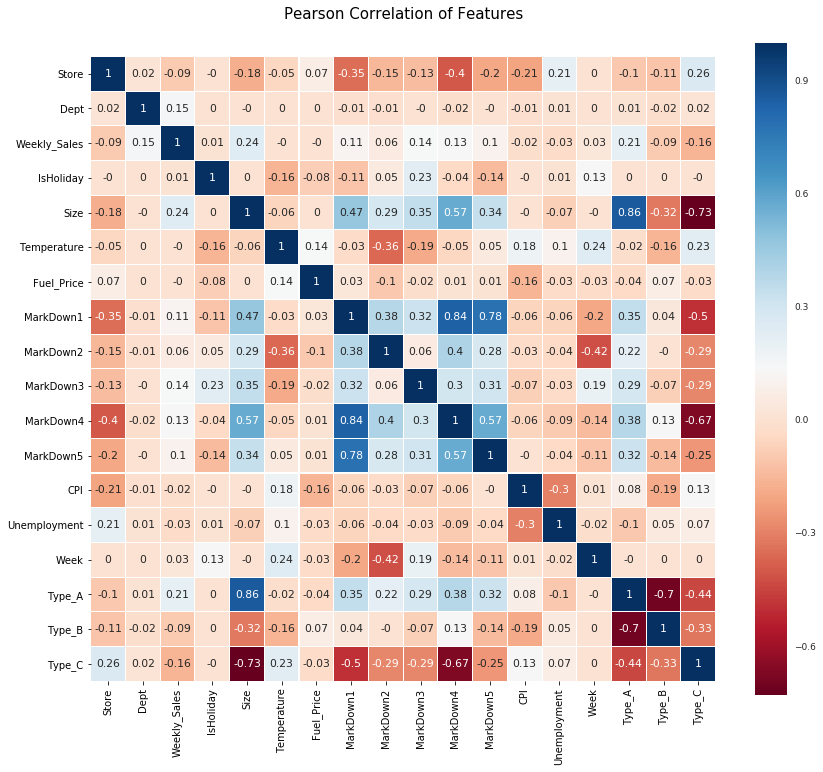

In [29]:
colormap = plt.cm.RdBu
corr = train_scaled.astype(float).corr()

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.set(font_scale=0.9)
sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [30]:
corr_cutoff = 0.8
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_cutoff:
            if columns[j]:
                columns[j] = False
                
selected_columns = train_scaled.columns[columns]
highcorr_columns = train_scaled.columns.difference(selected_columns)

In [31]:
highcorr_columns

Index(['MarkDown4', 'Type_A'], dtype='object')

In [32]:
train_scaled.drop(columns=highcorr_columns, axis=1, inplace=True)
test_scaled.drop(columns=highcorr_columns, axis=1, inplace=True)

###### Takeaway: 
1. MarkDown4 and Type_A are highly correlated to other existing features and have been dropped. 

train_scaled.drop(columns=['Temperature', 'Fuel_Price'], axis=1, inplace=True)
test_scaled.drop(columns=['Temperature', 'Fuel_Price'], axis=1, inplace=True)

In [33]:
weekly_sales = train_scaled['Weekly_Sales']
train_scaled = train_scaled.drop('Weekly_Sales', axis = 1)

### Split Training dataset into Train & Validation

In [34]:
train_X, val_X, train_y, val_y = train_test_split(train_scaled, weekly_sales, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [35]:
# Validate shape
train_X.shape,val_X.shape, test_scaled.shape

((337256, 15), (84314, 15), (115064, 15))

In [36]:
# Free up memory
train_scaled = weekly_sales = None

## 4. Modelling

### Select and evaluate candidate models

In [89]:
%%time
# Initialize base models
model_A = LinearRegression()
model_B = ElasticNet(random_state=1)
model_C = RandomForestRegressor(random_state=1)
model_D = GradientBoostingRegressor(random_state=1)
model_E = xgb.XGBRegressor()
model_F = LGBMRegressor(random_state=1)

samples = len(train_y) # 100% of training set

# Collect results on the learners
results = {}
for model in [model_A, model_B, model_C, model_D, model_E, model_F]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples]):
        results[model_name][i] = eval_train_predict(model, samples, train_X, train_y, val_X, val_y)

LinearRegression trained on 337256 samples.
ElasticNet trained on 337256 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 337256 samples.
[08:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 337256 samples.
CPU times: user 1min 35s, sys: 419 ms, total: 1min 35s
Wall time: 1min 36s


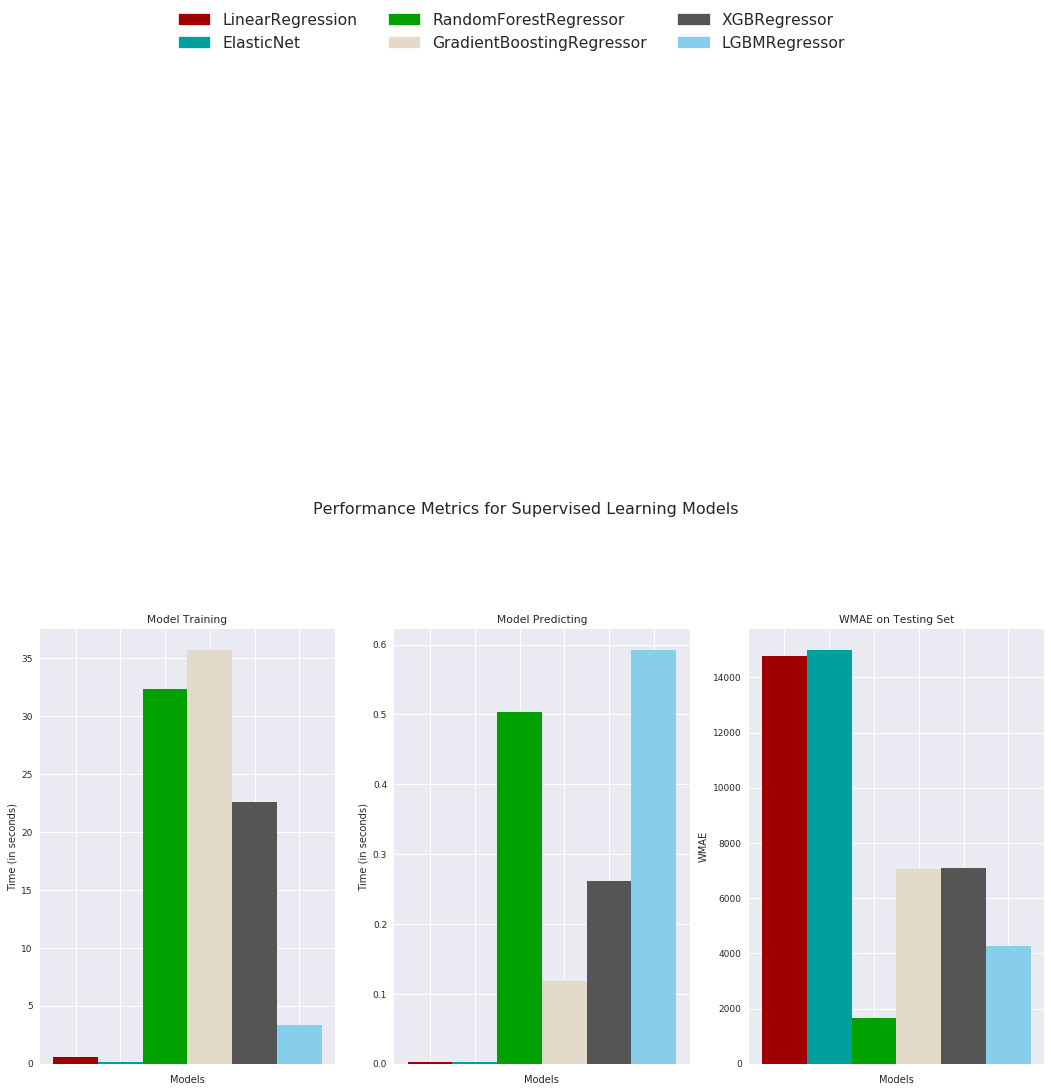

In [90]:
# Evaluate Metrics
eval_visualize(results)

In [91]:
results

{'LinearRegression': {0: {'time_train': 0.5686757564544678,
   'time_pred': 0.003078937530517578,
   'WMAE': 14774.641990009495}},
 'ElasticNet': {0: {'time_train': 0.13800740242004395,
   'time_pred': 0.002748727798461914,
   'WMAE': 15006.957927620455}},
 'RandomForestRegressor': {0: {'time_train': 32.337730169296265,
   'time_pred': 0.5040295124053955,
   'WMAE': 1656.8726492618043}},
 'GradientBoostingRegressor': {0: {'time_train': 35.72816324234009,
   'time_pred': 0.11783385276794434,
   'WMAE': 7059.007466413622}},
 'XGBRegressor': {0: {'time_train': 22.58227777481079,
   'time_pred': 0.2611682415008545,
   'WMAE': 7084.572590213446}},
 'LGBMRegressor': {0: {'time_train': 3.389556407928467,
   'time_pred': 0.592731237411499,
   'WMAE': 4277.553441722743}}}

###### Takeaway: With respect to WMAE, Random Forest and Light GBM have turned out to be the top performing base models and would be further evaluated.

### Evaluate Random Forest (Ensemble)

#### Default Model

In [23]:
model_rf_base = RandomForestRegressor(random_state=42, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


Learner Name : RandomForestRegressor
Training     : 33.77 secs / 337256 records
Predicting   : 0.5 secs / 84314 records
Weighted MAE : 1672.55

<Feature Importance>



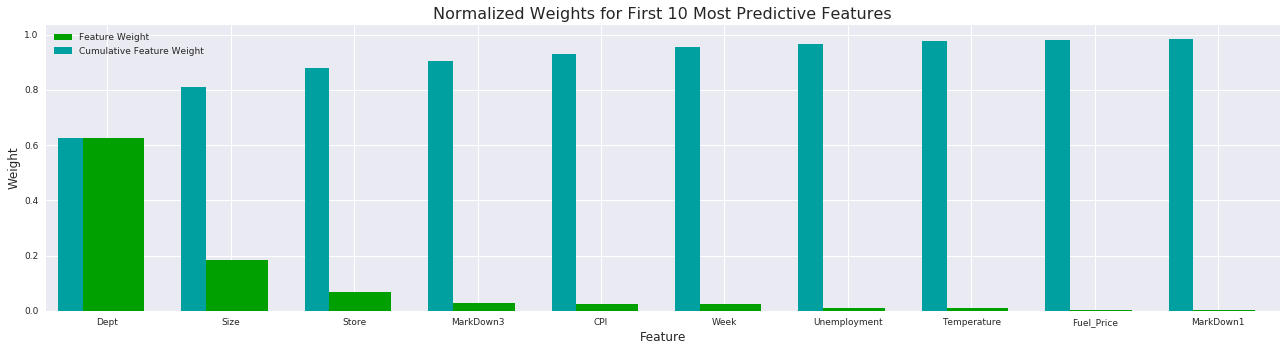


<Feature Weightage>

	Dept           : 0.625744502800423
	Size           : 0.18423764686973634
	Store          : 0.0684034171309138
	MarkDown3      : 0.027352278450841365
	CPI            : 0.025631375183277055
	Week           : 0.025335328588700655
	Unemployment   : 0.010374219597005588
	Temperature    : 0.009651665245372452
	Fuel_Price     : 0.004128744488994445
	MarkDown1      : 0.004014644217991354
	MarkDown5      : 0.0038024455438074346
	MarkDown2      : 0.0035294691724937965
	Type_C         : 0.00333145275967772
	Type_B         : 0.003149338808889939
	IsHoliday      : 0.0013134711418749734

<Learner Params>
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


In [26]:
model_rf_base, pred_y_rf_val = train_predict(model, train_X, train_y, val_X, val_y, verbose=1)

In [28]:
#pred_y_rf_val = model.predict(val_X)
pred_y_rf_test = model_rf_base.predict(test_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


In [24]:
param_grid = { 
    'n_estimators': [10, 50, 100, 150],
    'max_features': [None, 'auto'],
    'bootstrap': [True, False],
    'max_depth':[None],
    'random_state': [42], 
    'verbose': [1]
}

In [25]:
%%time
CV = GridSearchCV(estimator=model_rf_base, param_grid=param_grid, cv=2, verbose=1)
CV.fit(train_X, train_y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    9.8s finished
[Parallel(n_j

CPU times: user 48min 42s, sys: 8.59 s, total: 48min 51s
Wall time: 48min 52s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.9min finished


In [27]:
CV.best_params_ # latest

{'bootstrap': True,
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 150,
 'random_state': 42,
 'verbose': 1}

In [28]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

NameError: name 'model' is not defined

#### Tuned Model

In [37]:
model = RandomForestRegressor(random_state=42, 
                              n_estimators=150, 
                              bootstrap=True, 
                              max_features=None, 
                              max_depth=None, 
                              min_samples_leaf=1,
                              min_samples_split=3,
                              verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.3s finished


Learner Name : RandomForestRegressor
Training     : 472.92 secs / 337256 records
Predicting   : 6.33 secs / 84314 records
Weighted MAE : 1575.16

<Feature Importance>



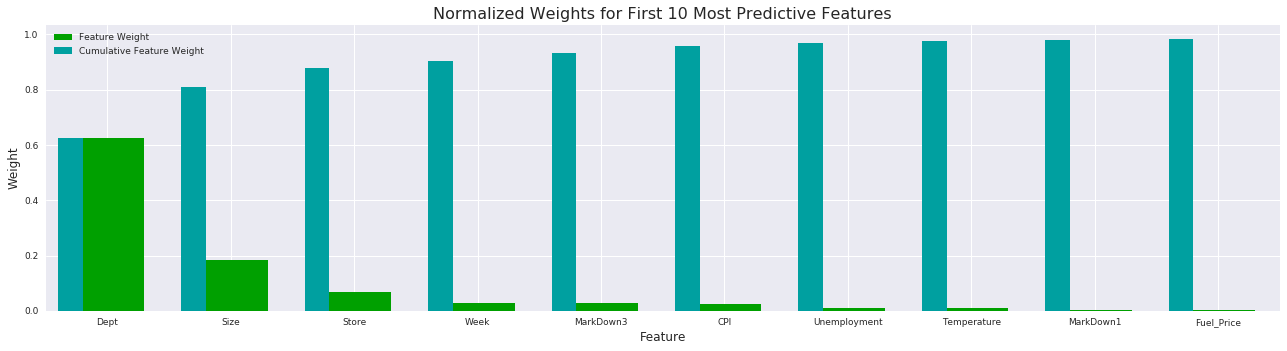


<Feature Weightage>

	Dept           : 0.6250793574344988
	Size           : 0.18445624573534627
	Store          : 0.06855207600205936
	Week           : 0.026906716108050503
	MarkDown3      : 0.026709520459252203
	CPI            : 0.025255933932968305
	Unemployment   : 0.010421515017031759
	Temperature    : 0.009166881046388393
	MarkDown1      : 0.004119728330847388
	Fuel_Price     : 0.0039113763362959705
	MarkDown5      : 0.0038549604377399065
	Type_B         : 0.0038044532964432508
	Type_C         : 0.003479351793556413
	MarkDown2      : 0.0033722542449879933
	IsHoliday      : 0.0009096298245336268

<Learner Params>
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


In [38]:
model, pred_y_rf_val = train_predict(model, train_X, train_y, val_X, val_y, verbose=1)

In [39]:
pred_y_rf_test = model.predict(test_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.8s finished


### Evaluate Light GBM (Boosting)

#### Default Model

In [40]:
# Default model
model = LGBMRegressor()

Learner Name : LGBMRegressor
Training     : 2.77 secs / 337256 records
Predicting   : 0.35 secs / 84314 records
Weighted MAE : 4269.28

<Feature Importance>



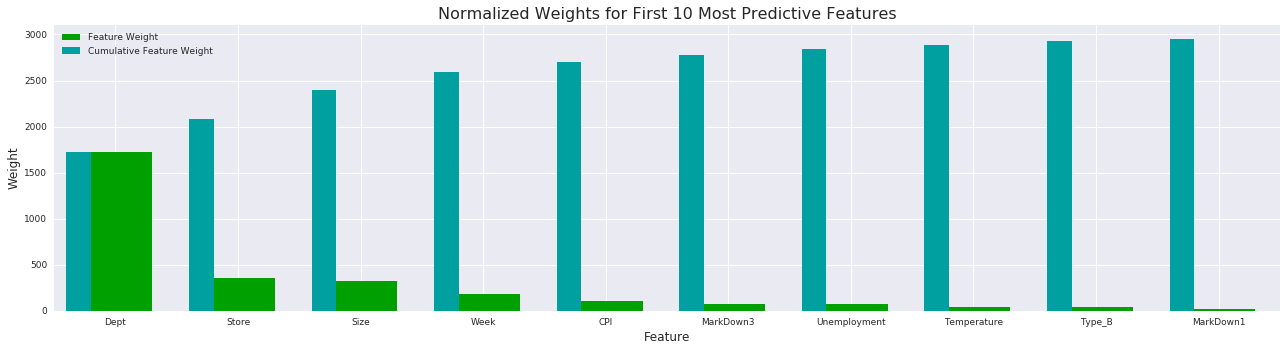


<Feature Weightage>

	Dept           : 1725
	Store          : 354
	Size           : 323
	Week           : 187
	CPI            : 107
	MarkDown3      : 78
	Unemployment   : 69
	Temperature    : 46
	Type_B         : 44
	MarkDown1      : 21
	Fuel_Price     : 13
	IsHoliday      : 13
	MarkDown2      : 11
	MarkDown5      : 7
	Type_C         : 2

<Learner Params>
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [41]:
model, pred_y_lgbm_val = train_predict(model, train_X, train_y, val_X, val_y, verbose=1)

In [27]:
param_grid = {
    'boosting_type': ['gbdt'], 
    'objective': ['regression'],
    'random_state': [42],
    'min_data_in_leaf':[2,3,4,5],
    'min_depth':[3,4,5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 500, 1000, 2000, 3000],
    'num_leaves': [30, 40, 60, 80]
}

In [ ]:
%%time
#CV_lgbm = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, scoring='neg_mean_absolute_error')
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
CV.fit(train_X, train_y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [30]:
#print("Best parameter (CV score=%0.3f):" % CV.best_score_)
print(CV.best_params_)

{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 5, 'min_data_in_leaf': 2, 'min_depth': 3, 'n_estimators': 3000, 'num_leaves': 80, 'objective': 'regression', 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 2}


In [31]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_data_in_leaf=2,
       min_depth=3, min_split_gain=0.0, n_estimators=3000, n_jobs=-1,
       num_leaves=80, objective='regression', random_state=42,
       reg_alpha=0.1, reg_lambda=2, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

#### Default Model

In [27]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                      importance_type='split', learning_rate=0.3, max_depth=-1,
                      min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
                      n_estimators=3000, n_jobs=-1, num_leaves=60, objective='regression',
                      random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
                      subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
                      verbose=1)

In [ ]:
model = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                      importance_type='split', learning_rate=0.3, max_depth=-1,
                      min_child_samples=5, min_child_weight=0.001, min_data_in_leaf=2,
                      min_depth=3, min_split_gain=0.0, n_estimators=3000, n_jobs=-1,
                      num_leaves=80, objective='regression', random_state=42,
                      reg_alpha=0.1, reg_lambda=2, silent=True, subsample=1.0,
                      subsample_for_bin=200000, subsample_freq=0,
                      verbose=1)

Learner Name : LGBMRegressor
Training     : 42.02 secs / 337256 records
Predicting   : 10.1 secs / 84314 records
Weighted MAE : 1479.05

<Feature Importance>



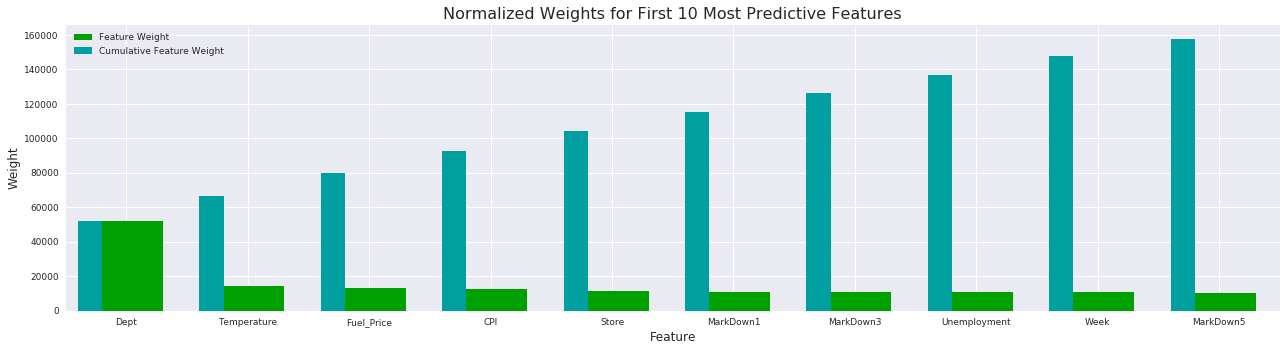


<Feature Weightage>

	Dept           : 52090
	Temperature    : 14440
	Fuel_Price     : 13416
	CPI            : 12709
	Store          : 11440
	MarkDown1      : 11153
	MarkDown3      : 11005
	Unemployment   : 10790
	Week           : 10751
	MarkDown5      : 10036
	Size           : 9472
	MarkDown2      : 8339
	IsHoliday      : 748
	Type_B         : 602
	Type_C         : 9

<Learner Params>
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.3, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 3000, 'n_jobs': -1, 'num_leaves': 60, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 2, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': 1}


In [28]:
model, pred_y_lgbm_val = train_predict(model, train_X, train_y, val_X, val_y, verbose=1)

In [29]:
pred_y_lgbm_test = model.predict(test_scaled)

## Model Stacking

In [30]:
# Blend the results of the two regressors and save the prediction to a CSV file.
pred_y_val = (pred_y_rf_val * 0.8) + (pred_y_lgbm_val * 0.2)
pred_y = (pred_y_rf_test * 0.8) + (pred_y_lgbm_test * 0.2)
pred_y = np.exp(pred_y)

In [31]:
# make predictions
print("Weighted Mean Absolute Error: ", weighted_mean_absolute_error(pred_y_val, val_y, compute_weights(val_X['IsHoliday'])))

Weighted Mean Absolute Error:  1454.4252669889693


In [43]:
submission['Weekly_Sales'] = pred_y

In [44]:
submission[['Id','Weekly_Sales']].to_csv('submission.csv', index=False)